In [1]:
## Run this so that the Original Code can pull and clone the Github repository and install it
!git clone https://github.com/zexyang/RUL_prediction_ME599.git
%cd RUL_prediction_ME599
!cat README.md

Cloning into 'RUL_prediction_ME599'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 51 (delta 13), reused 28 (delta 8), pack-reused 18
Receiving objects: 100% (51/51), 57.80 MiB | 7.42 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (22/22), done.
/content/RUL_prediction_ME599
# A Hybrid CNN-LSTM for Battery Remaining Useful Life Prediction with Charging Profiles Data
[![DOI:10.1145/3575882.3575903](http://img.shields.io/badge/DOI-10.1145/3575882.3575903-1481c1.svg)](https://doi.org/10.1145/3575882.3575903)

+ Battery RUL prediction using data-driven method based on a hybrid deep model of Convolutional Neural Networks (CNN) and Long-Short Term Memory (LSTM).
+ CNN and LSTM are used to extract features from multiple measurable data (Voltage, Current, Temperature, Capacity) in parallel.
+ CNN extracts features of multi-channel charging profiles, whereas LSTM extr

train X: ['data/NASA/charge/train/B0005_charge.csv', 'data/NASA/charge/train/B0006_charge.csv', 'data/NASA/charge/train/B0007_charge.csv']
train Y: ['data/NASA/discharge/train/B0005_discharge.csv', 'data/NASA/discharge/train/B0006_discharge.csv', 'data/NASA/discharge/train/B0007_discharge.csv']

Fold 1
train X: ['data/NASA/charge/train/B0006_charge.csv', 'data/NASA/charge/train/B0007_charge.csv']
train y: ['data/NASA/discharge/train/B0006_discharge.csv', 'data/NASA/discharge/train/B0007_discharge.csv']
val X: ['data/NASA/charge/train/B0005_charge.csv']
val y ['data/NASA/discharge/train/B0005_discharge.csv']
test: x ['data/NASA/charge/test/B0018_charge.csv']
test: y ['data/NASA/discharge/test/B0018_discharge.csv']
Input shape: (326, 5, 1)
Input shape: (326, 5, 10)
Input shape: (326, 5, 10)
Input shape: (326, 5, 10)
Epoch 1/100
7/7 [==============================] - 5s 159ms/step - loss: 0.1172 - val_loss: 0.0437
Epoch 2/100
7/7 [==============================] - 0s 51ms/step - loss: 0.0

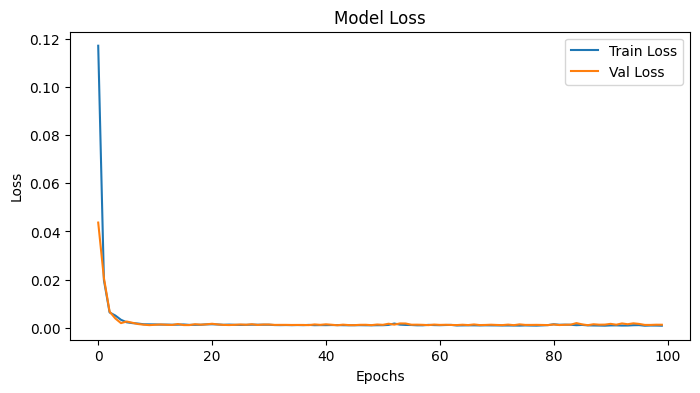

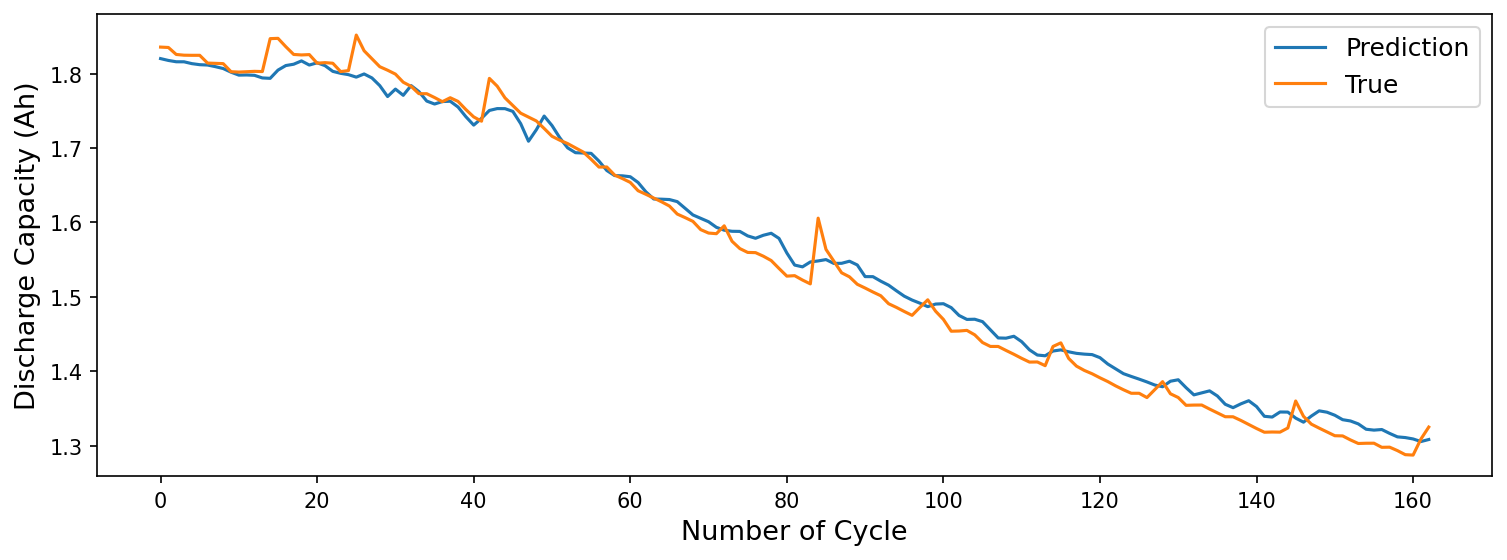

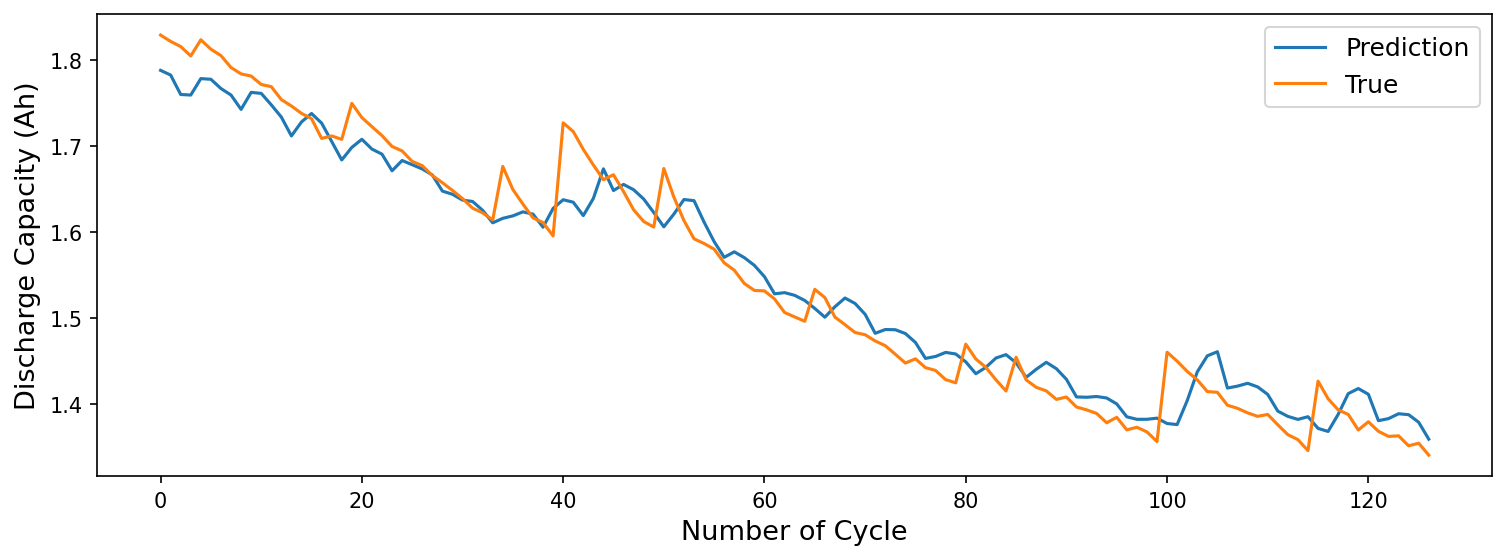

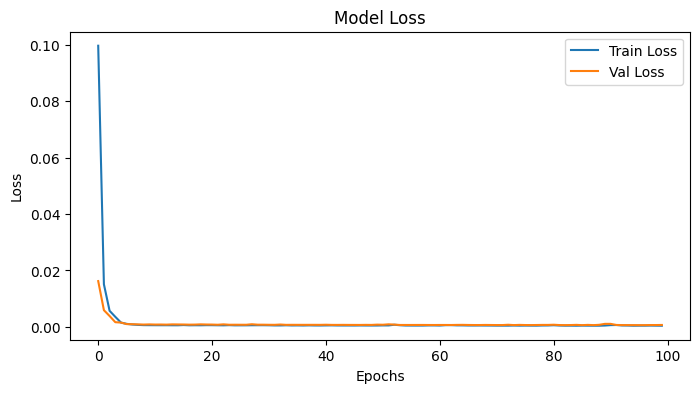

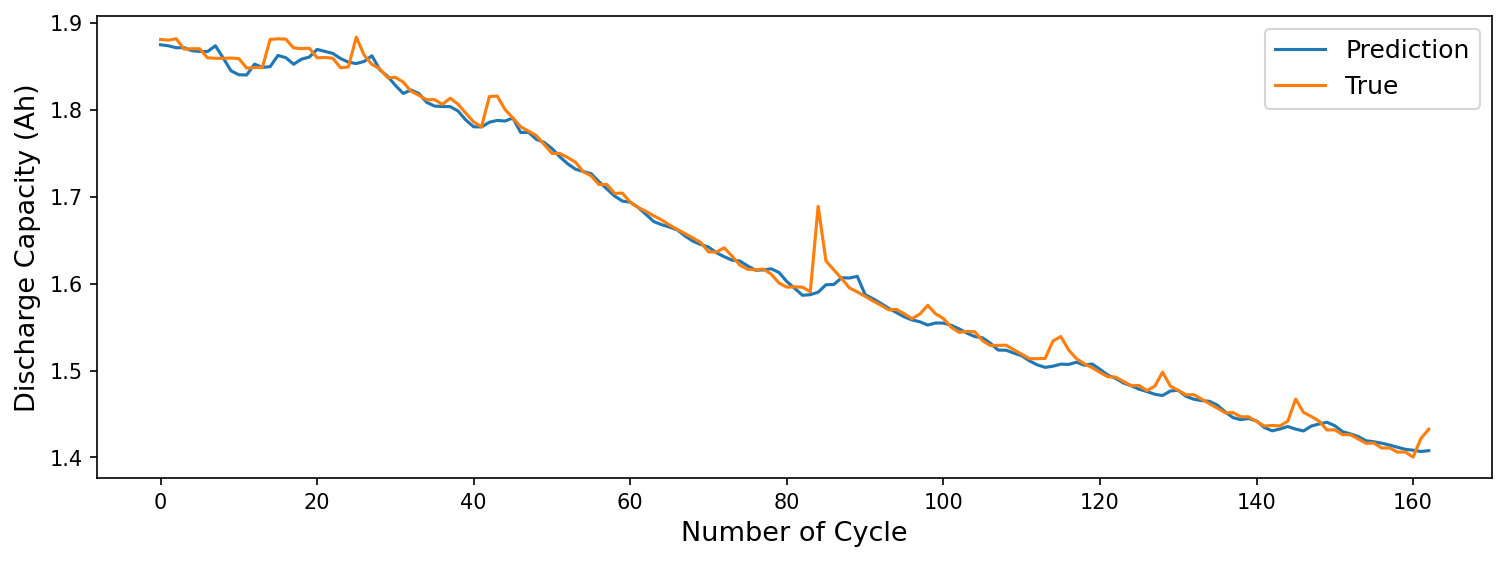

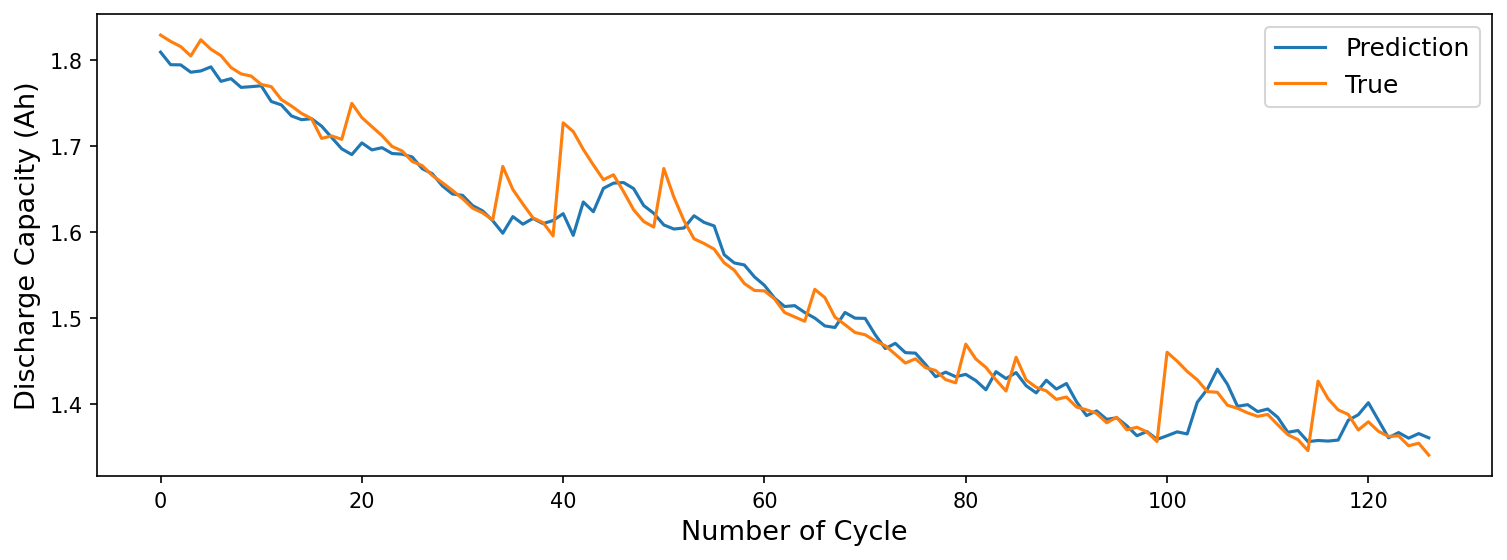

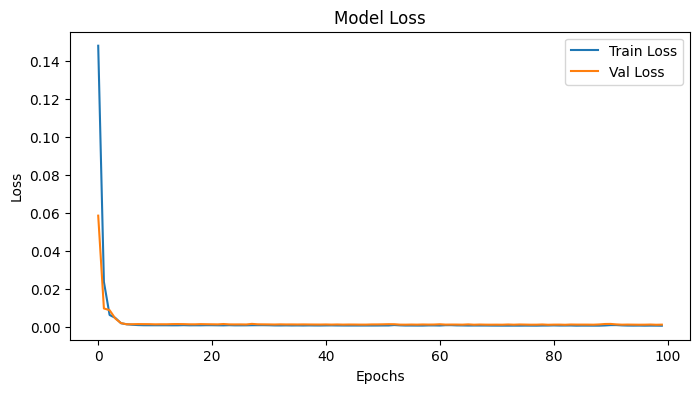

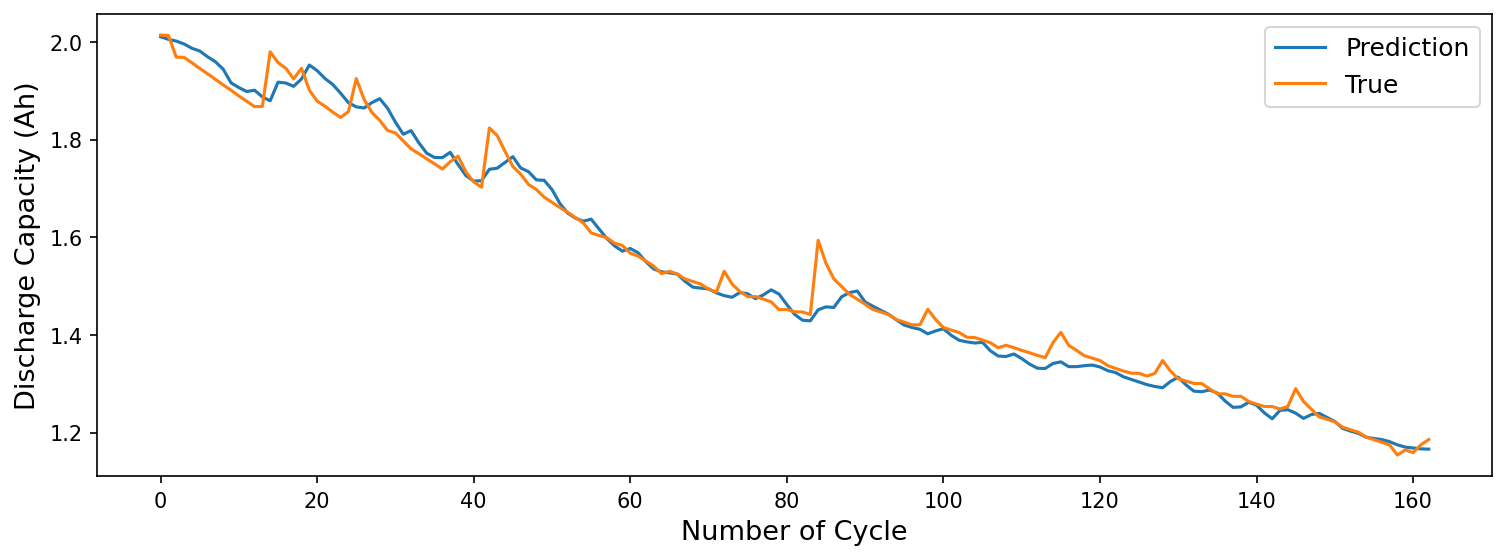

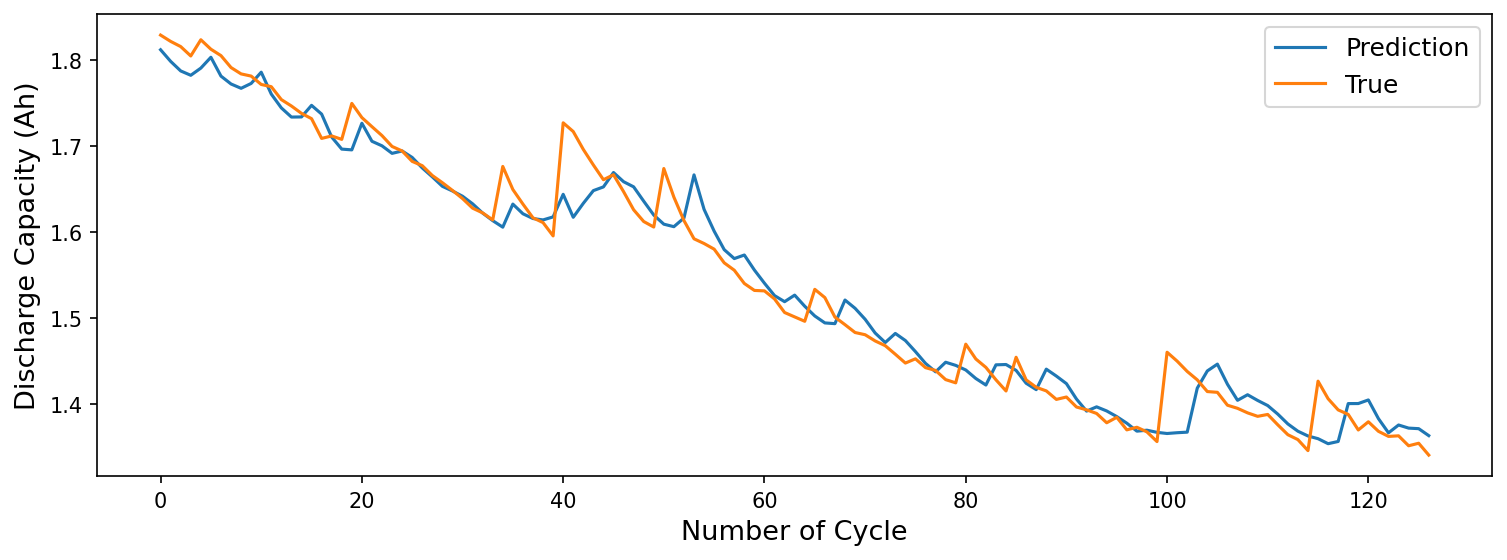

In [2]:
import random as rn
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import json
import re
import RUL_prediction_ME599.train.param_separated as pr ###Changed from "import param_separated as pr"
import RUL_prediction_ME599.train.utils_new as utils ###Changed from "import utils_new as utils"
import RUL_prediction_ME599.train.utils as utilss ###Changed from "import utils as utilss"


SEED = 12345
os.environ["CUDA_VISIBLE_DEVICES"] = str(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
rn.seed(SEED)
tf.compat.v1.random.set_random_seed(SEED)
tf.random.set_seed(SEED)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


def main():
    pth = pr.pth
    train_x_files = [os.path.join(pth, 'charge/train', f) for f in os.listdir(os.path.join(pth, 'charge/train'))]
    train_x_files.sort(key=lambda f: int(re.sub('\D', '', f)))
    train_y_files = [os.path.join(pth, 'discharge/train', f) for f in os.listdir(os.path.join(pth, 'discharge/train'))]
    train_y_files.sort(key=lambda f: int(re.sub('\D', '', f)))
    test_x_data = [os.path.join(pth, 'charge/test', f) for f in os.listdir(os.path.join(pth, 'charge/test'))]
    test_y_data = [os.path.join(pth, 'discharge/test', f) for f in os.listdir(os.path.join(pth, 'discharge/test'))]
    print("train X:", train_x_files)
    print("train Y:", train_y_files)

    folds = list(KFold(n_splits=pr.k, shuffle=True, random_state=pr.random, ).split(train_x_files))

    for j, (train_idx, val_idx) in enumerate(folds):
        print('\nFold', j + 1)
        train_x_data = [train_x_files[train_idx[i]] for i in range(len(train_idx))]
        train_y_data = [train_y_files[train_idx[i]] for i in range(len(train_idx))]
        val_x_data = [train_x_files[val_idx[i]] for i in range(len(val_idx))]
        val_y_data = [train_y_files[val_idx[i]] for i in range(len(val_idx))]
        print("train X:", train_x_data)
        print("train y:", train_y_data)
        print("val X:", val_x_data)
        print("val y", val_y_data)
        print("test: x", test_x_data)
        print("test: y", test_y_data)

        # data lstm
        trainX_lstm, trainY_lstm, SS_tr_lstm = utils.extract_VIT_capacity(train_x_data, train_y_data, pr.seq_len_lstm, pr.hop, pr.sample,
                                                                          c=True)
        valX_lstm, valY_lstm, SS_val_lstm = utils.extract_VIT_capacity(val_x_data, val_y_data, pr.seq_len_lstm, pr.hop, pr.sample,
                                                                       c=True)
        testX_lstm, testY_lstm, SS_tt_lstm = utils.extract_VIT_capacity(test_x_data, test_y_data, pr.seq_len_lstm, pr.hop, pr.sample,
                                                                        c=True)
        print('Input shape: {}'.format(trainX_lstm.shape))

        # data cnn (v)
        v_trainX_cnn, v_trainY_cnn, v_SS_tr_cnn = utils.extract_VIT_capacity(train_x_data, train_y_data, pr.seq_len_cnn, pr.hop, pr.sample,
                                                                             v=True)
        v_valX_cnn, v_valY_cnn, v_SS_val_cnn = utils.extract_VIT_capacity(val_x_data, val_y_data, pr.seq_len_cnn, pr.hop, pr.sample,
                                                                          v=True)
        v_testX_cnn, v_testY_cnn, v_SS_tt_cnn = utils.extract_VIT_capacity(test_x_data, test_y_data, pr.seq_len_cnn, pr.hop, pr.sample,
                                                                           v=True)
        print('Input shape: {}'.format(v_trainX_cnn.shape))

        # data cnn (i)
        i_trainX_cnn, i_trainY_cnn, i_SS_tr_cnn = utils.extract_VIT_capacity(train_x_data, train_y_data, pr.seq_len_cnn, pr.hop, pr.sample,
                                                                             II=True)
        i_valX_cnn, i_valY_cnn, i_SS_val_cnn = utils.extract_VIT_capacity(val_x_data, val_y_data, pr.seq_len_cnn, pr.hop, pr.sample,
                                                                          II=True)
        i_testX_cnn, i_testY_cnn, i_SS_tt_cnn = utils.extract_VIT_capacity(test_x_data, test_y_data, pr.seq_len_cnn, pr.hop, pr.sample,
                                                                           II=True)
        print('Input shape: {}'.format(i_trainX_cnn.shape))

        # data cnn (t)
        t_trainX_cnn, t_trainY_cnn, t_SS_tr_cnn = utils.extract_VIT_capacity(train_x_data, train_y_data, pr.seq_len_cnn, pr.hop, pr.sample,
                                                                             t=True)
        t_valX_cnn, t_valY_cnn, t_SS_val_cnn = utils.extract_VIT_capacity(val_x_data, val_y_data, pr.seq_len_cnn, pr.hop, pr.sample,
                                                                          t=True)
        t_testX_cnn, t_testY_cnn, t_SS_tt_cnn = utils.extract_VIT_capacity(test_x_data, test_y_data, pr.seq_len_cnn, pr.hop, pr.sample,
                                                                           t=True)
        print('Input shape: {}'.format(t_trainX_cnn.shape))

        # define inputs
        input_CNN_v = Input(shape=(pr.seq_len_cnn, v_trainX_cnn.shape[-1]), name="CNN_Input_V")
        input_CNN_i = Input(shape=(pr.seq_len_cnn, i_trainX_cnn.shape[-1]), name="CNN_Input_i")
        input_CNN_t = Input(shape=(pr.seq_len_cnn, t_trainX_cnn.shape[-1]), name="CNN_Input_t")

        input_LSTM = Input(shape=(pr.seq_len_lstm, trainX_lstm.shape[-1]), name="LSTM_Input")

        # define LSTM layer

        LSTM_layer = LSTM(400,
                          activation='tanh',
                          return_sequences=True,
                          name="LSTM_layer")(input_LSTM)

        # define CNN layer

        CNN_layer_v = Conv1D(32, 5, activation='relu',
                             strides=1, padding="same",
                             name="CNN_layer_v")(input_CNN_v)

        CNN_layer_i = Conv1D(32, 5, activation='relu',
                             strides=1, padding="same",
                             name="CNN_layer_i")(input_CNN_i)

        CNN_layer_t = Conv1D(32, 5, activation='relu',
                             strides=1, padding="same",
                             name="CNN_layer_t")(input_CNN_t)

        # fusion CNN
        concat_cnn = concatenate([CNN_layer_v, CNN_layer_i, CNN_layer_t])

        CNN_fusion = Conv1D(32, 5, activation='relu',
                            strides=1, padding='same',
                            name="CNN_fusion")(concat_cnn)

        concat = concatenate([LSTM_layer, CNN_fusion])

        flat = Flatten()(concat)
        output = Dense(32, activation='relu', name="Predictor")(flat)
        output = Dense(1, name="Output")(output)

        model = Model(inputs=[input_LSTM, input_CNN_v, input_CNN_i, input_CNN_t], outputs=[output])

        optim = Adam(learning_rate=pr.lr)
        model.compile(loss='mse', optimizer=optim)

        history = model.fit(x=[trainX_lstm, v_trainX_cnn, i_trainX_cnn, t_trainX_cnn],
                            y=[trainY_lstm, v_trainY_cnn, i_trainY_cnn, t_trainY_cnn],
                            validation_data=([valX_lstm, v_valX_cnn, i_valX_cnn, t_valX_cnn],
                                             [valY_lstm, v_valY_cnn, i_valY_cnn, t_valY_cnn]),
                            batch_size=pr.batch_size,
                            epochs=pr.epochs)

        save_dir = pr.save_dir
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        model_dir = pr.model_dir + '_k' + str(j + 1)
        if not os.path.exists(os.path.join(save_dir, model_dir)):
            os.makedirs(os.path.join(save_dir, model_dir))

        model.save(save_dir + model_dir + "/saved_model_and_weight")
        print("bobot dan model tersimpan")

        # Evaluate on validation and test data
        val_loss = []
        val_results = model.evaluate([valX_lstm, v_valX_cnn, i_valX_cnn, t_valX_cnn],
                                     [valY_lstm, v_valY_cnn, i_valY_cnn, t_valY_cnn])
        val_loss.append(val_results)
        print('Val loss:', val_results)

        test_loss = []
        results = model.evaluate([testX_lstm, v_testX_cnn, i_testX_cnn, t_testX_cnn],
                                 [testY_lstm, v_testY_cnn, i_testY_cnn, t_testY_cnn])
        test_loss.append(results)
        print('Test loss:', results)

        # Prediction
        valPredict = model.predict([valX_lstm, v_valX_cnn, i_valX_cnn, t_valX_cnn])
        testPredict = model.predict([testX_lstm, v_testX_cnn, i_testX_cnn, t_testX_cnn])

        # Inverse transform MinMaxScaler / denormalize
        inv_valY = SS_val_lstm.inverse_transform(v_valY_cnn)
        inv_valPredict = SS_val_lstm.inverse_transform(valPredict)

        inv_testY = SS_tt_lstm.inverse_transform(v_testY_cnn)
        inv_testPredict = SS_tt_lstm.inverse_transform(testPredict)

        # get evaluation metrics ontest data
        test_mae = mean_absolute_error(inv_testY, inv_testPredict)
        test_mse = mean_squared_error(inv_testY, inv_testPredict)
        test_mape = mean_absolute_percentage_error(inv_testY, inv_testPredict)
        test_rmse = np.sqrt(mean_squared_error(inv_testY, inv_testPredict))
        print('\nTest Mean Absolute Error: %f MAE' % test_mae)
        print('Test Mean Square Error: %f MSE' % test_mse)
        print('Test Mean Absolute Percentage Error: %f MAPE' % test_mape)
        print('Test Root Mean Squared Error: %f RMSE' % test_rmse)

        # Save evaluation metrics
        with open(os.path.join(save_dir, model_dir, 'eval_metrics.txt'), 'w') as f:
            f.write('Train data: ')
            f.write(json.dumps(train_x_data))
            f.write('\nVal data: ')
            f.write(json.dumps(val_x_data))
            f.write('\nTest data: ')
            f.write(json.dumps(test_x_data))
            f.write('\n\nTest Mean Absolute Error: ')
            f.write(json.dumps(str(test_mae)))
            f.write('\nTest Mean Square Error: ')
            f.write(json.dumps(str(test_mse)))
            f.write('\nTest Mean Absolute Percentage Error: ')
            f.write(json.dumps(str(test_mape)))
            f.write('\nTest Root Mean Squared Error: ')
            f.write(json.dumps(str(test_rmse)))

        # Save test prediction to text file
        testPred_file = open(os.path.join(save_dir, model_dir, 'test_predict.txt'), 'w')
        for row in inv_testPredict:
            np.savetxt(testPred_file, row)
        testPred_file.close()

        testY_file = open(os.path.join(save_dir, model_dir, 'test_true.txt'), 'w')
        for row in inv_testY:
            np.savetxt(testY_file, row)
        testY_file.close()

        # plot graph
        utilss.plot_loss(history, save_dir, model_dir)
        utilss.plot_pred(inv_valPredict, inv_valY, save_dir, model_dir, "val_pred")
        utilss.plot_pred(inv_testPredict, inv_testY, save_dir, model_dir, "test_pred")


if __name__ == "__main__":
    main()